In [1]:
import glob
from multiprocessing import Pool
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from scipy.interpolate import interp1d
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import time


from itertools import groupby
from operator import itemgetter
import pickle as pkl
import re


from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [2]:
pos_replacement={'pos':dict(zip(["noun","verb","adj"],['n','v','a']))}
unigram_list=["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o",  "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

br_to_us=pd.read_excel("Book.xlsx")
br_to_us_dict=dict(zip(br_to_us.UK.tolist(),br_to_us.US.tolist()))

adv_dict=dict(zip(['adv'],['r']))

adv_replacement={'pos':adv_dict}
spelling_replacement={'word':br_to_us_dict}
num_cores=20

In [3]:
def patternmaker(x):
    x=np.array(x.notnull())
    x=x.astype(int)
    #print(x)
    val = ''.join(map(str, x))
    #print(val)
    return val

In [4]:
def lemma_maker(x, y):
    #print(x,y)
    return lemmatizer.lemmatize(x,y)



In [5]:
def reducer(df):
    if df.empty==True:
        return df

        
    df['context'],df['pos']=df['context_pos'].str.split('_', 1).str

        
    df.drop(["context_pos"],axis=1,inplace=True)
    df.replace(adv_replacement,inplace=True)
    df['pos']=df['pos'].str[0]
    df.replace(pos_replacement,inplace=True)
    df.dropna(inplace=True)
    df['context']=np.vectorize(lemma_maker)(df['context'], df['pos'])
    df.replace(spelling_replacement,inplace=True)
    df['context']=df['context']+"_"+df['pos']
   
    df.groupby(['context'])['count'].sum().to_frame()
    df.drop(['pos'],axis=1,inplace=True)
    return df

In [6]:
def chunked_dataset_extracter(df):
    df.columns=['context_pos','count']
    df.context_pos=df.context_pos.str.lower()
    df=df.loc[df.context_pos.str.match("^[a-z-]+_(noun|verb|adj|adv)$",na=False)]
    df=df.groupby(['context_pos'])['count'].sum().to_frame()
    df.reset_index(inplace=True)
    return df

In [7]:
def dataset_extracter(letter):
    CHUNKSIZE = 1_000_000
    print("Started with letters "+letter)
    cur_time=time.time()
    
    df_list=[]
    path_loc="http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-all-1gram-20120701-"+letter+".gz"
    dfs   = pd.read_csv(path_loc, compression='gzip', header=None, sep="\t", quotechar='"',usecols=[0,2],chunksize=CHUNKSIZE)
    for df in dfs:
        df_list.append(chunked_dataset_extracter(df))
    complete_df=pd.concat(df_list)
    total_contexts=reducer(complete_df)
    print("Finished with letters "+letter)
    print("Letters "+letter+" took time "+str(round(time.time()-cur_time,3))+" seconds")
    print("\n")
    return total_contexts

In [8]:
context_list=[]
pool = Pool(num_cores)
print("Started with letter "+str(unigram_list))
for temp_contexts in pool.imap_unordered(dataset_extracter,unigram_list):
    context_list.append(temp_contexts)
        
pool.close()
pool.join()
contexts = pd.concat(context_list)
contexts=contexts.groupby(['context'])['count'].sum().to_frame()
contexts.reset_index(inplace=True)

Started with letters a
Started with letters e
Started with letters b
Started with letters c
Started with letters h
Started with letters d
Started with letters f
Started with letters g
Started with letters i
Started with letters n
Started with letters s
Started with letters q
Started with letters o
Started with letters t
Started with letters p
Started with letters r
Started with letters m
Started with letters l
Started with letters j
Started with letters k
Started with letter ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Finished with letters q
Letters q took time 20.017 seconds


Started with letters u
Finished with letters j
Letters j took time 47.904 seconds


Started with letters v
Finished with letters u
Letters u took time 64.738 seconds


Started with letters w
Finished with letters k
Letters k took time 92.563 seconds


Started with letters x
Finished with letters x
Letters x took time 12.44 sec

In [10]:
contexts

,context,count
0,a-family_n,56
1,a_a,14766355
2,a_n,30179286
3,aa_a,116021
4,aa_n,2065678
5,aa_r,99815
6,aa_v,186216
7,aaa_a,24244
8,aaa_n,766785
9,aaa_r,290


In [21]:
chosen_context=contexts.sort_values('count',ascending=False).head(50_000)
chosen_context.context["of"]

KeyError: 'of'

In [13]:
context_pos=chosen_context.context.str[-1].value_counts().to_frame()
context_pos['perc']=round((context_pos['context']/context_pos['context'].sum())*100,3)
context_pos

,context,perc
n,30751,61.502
a,11901,23.802
v,5609,11.218
r,1739,3.478


In [88]:
context_first_letter=chosen_context.context.str[0].value_counts().to_frame()
context_first_letter['perc']=round((context_first_letter['context']/context_first_letter['context'].sum())*100,3)
context_first_letter

,context,perc
s,3154,10.513
c,2861,9.537
p,2413,8.043
a,2062,6.873
m,1778,5.927
d,1774,5.913
r,1617,5.390
b,1596,5.320
i,1382,4.607
t,1378,4.593


In [91]:
chosen_context

,context,count
402419,be_v,13539177597
1959581,have_v,3638096990
3259942,not_r,2257133899
1234067,do_v,1268417706
659217,can_v,831829941
5151646,when_r,759642983
2800280,make_v,756783810
5205631,would_v,734711601
5169322,will_v,707078848
3403305,other_a,690317805


Four extra columns are added, which are:

$cf$ : Collection frequency, which is the log of the sum of the term across decades, i.e. log(sum(term).

$presence$ : Number of decades a term is present in.

$pattern$ : A binary representation of a word. 1 if the $word$ exists in a decade, 0 otherwise.

In [14]:
with open('contexts.csv', 'w') as f1:
    chosen_context.to_csv(f1, header=True,sep="\t",index=False)

In [65]:
unigram.describe()

,1800s,1810s,1820s,1830s,1840s,1850s,1860s,1870s,1880s,1890s,...,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,cf
count,300162.000,382522.000,460552.000,500317.000,596820.000,733499.000,690248.000,801640.000,950707.000,1064839.000,...,1224739.000,1258588.000,1274439.000,1757529.000,2567353.000,3078854.000,3473243.000,4008253.000,4452554.000,5023231.000
mean,1.692,1.680,1.698,1.714,1.709,1.703,1.706,1.705,1.712,1.722,...,1.729,1.728,1.731,1.732,1.753,1.775,1.817,1.882,1.957,2.376
std,0.727,0.722,0.739,0.752,0.748,0.745,0.747,0.743,0.745,0.748,...,0.749,0.745,0.747,0.737,0.735,0.737,0.748,0.761,0.779,0.827
min,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
25%,1.176,1.176,1.176,1.176,1.176,1.176,1.176,1.176,1.176,1.204,...,1.204,1.204,1.204,1.204,1.230,1.255,1.279,1.342,1.398,1.820
50%,1.462,1.447,1.462,1.477,1.477,1.462,1.462,1.477,1.477,1.491,...,1.505,1.505,1.505,1.505,1.544,1.568,1.613,1.690,1.778,2.233
75%,1.954,1.934,1.959,1.982,1.978,1.964,1.968,1.968,1.982,1.996,...,2.013,2.013,2.013,2.021,2.049,2.079,2.134,2.217,2.312,2.775
max,7.553,7.735,7.926,8.049,8.140,8.272,8.206,8.299,8.419,8.497,...,8.586,8.563,8.567,8.742,8.989,9.092,9.183,9.346,9.540,10.130


In [66]:
pattern_counts=unigram.pattern.value_counts().to_frame()
pattern_counts['perc']=round((pattern_counts['pattern']/pattern_counts['pattern'].sum())*100,3)
pattern_counts.sort_index(inplace=True)
display(pattern_counts.head(10))
pattern_counts.tail(10)

,pattern,perc
000000000000000000001,206302,4.107
000000000000000000010,29886,0.595
000000000000000000011,398308,7.929
000000000000000000100,18256,0.363
000000000000000000101,37015,0.737
000000000000000000110,28502,0.567
000000000000000000111,414732,8.256
000000000000000001000,17632,0.351
000000000000000001001,23504,0.468
000000000000000001010,9110,0.181


,pattern,perc
111111111111111110001,4,0.000
111111111111111110011,14,0.000
111111111111111110101,2,0.000
111111111111111110111,22,0.000
111111111111111111001,22,0.000
111111111111111111011,170,0.003
111111111111111111100,1,0.000
111111111111111111101,45,0.001
111111111111111111110,3,0.000
111111111111111111111,186489,3.713


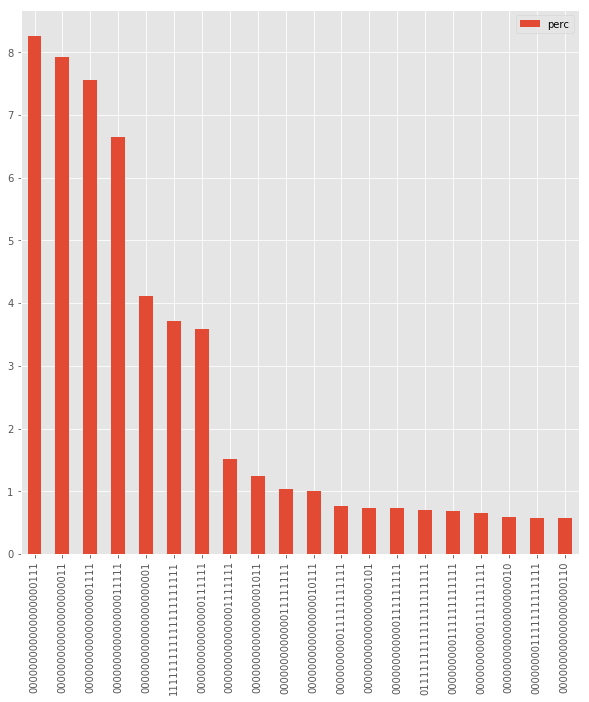

In [56]:
pattern_counts.sort_values('pattern', ascending=False).head(20).drop('pattern',axis=1).plot.bar(figsize=(10,10))

In [62]:
decade_presence=unigram.presence.value_counts().to_frame()
decade_presence['perc']=round((decade_presence.presence/decade_presence.presence.sum())*100,3)
decade_presence.sort_index(inplace=True)
decade_presence

,presence,perc
1,373732,7.440
2,685493,13.646
3,747613,14.883
4,662783,13.194
5,547768,10.905
6,379943,7.564
7,257363,5.123
8,192682,3.836
9,150933,3.005
10,126783,2.524


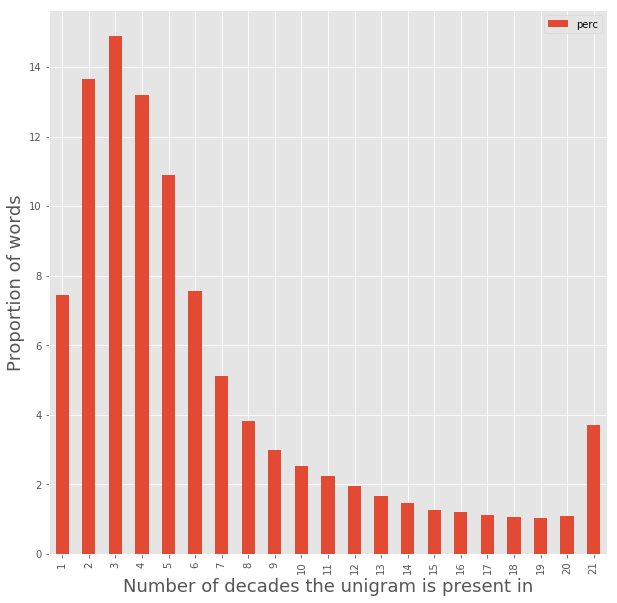

In [63]:
fig, ax = plt.subplots()
decade_presence.drop('presence',axis=1).plot.bar(ax=ax,figsize=(10,10))
plt.xlabel('Number of decades the unigram is present in', fontsize=18)
plt.ylabel('Proportion of words', fontsize=18)
plt.show()

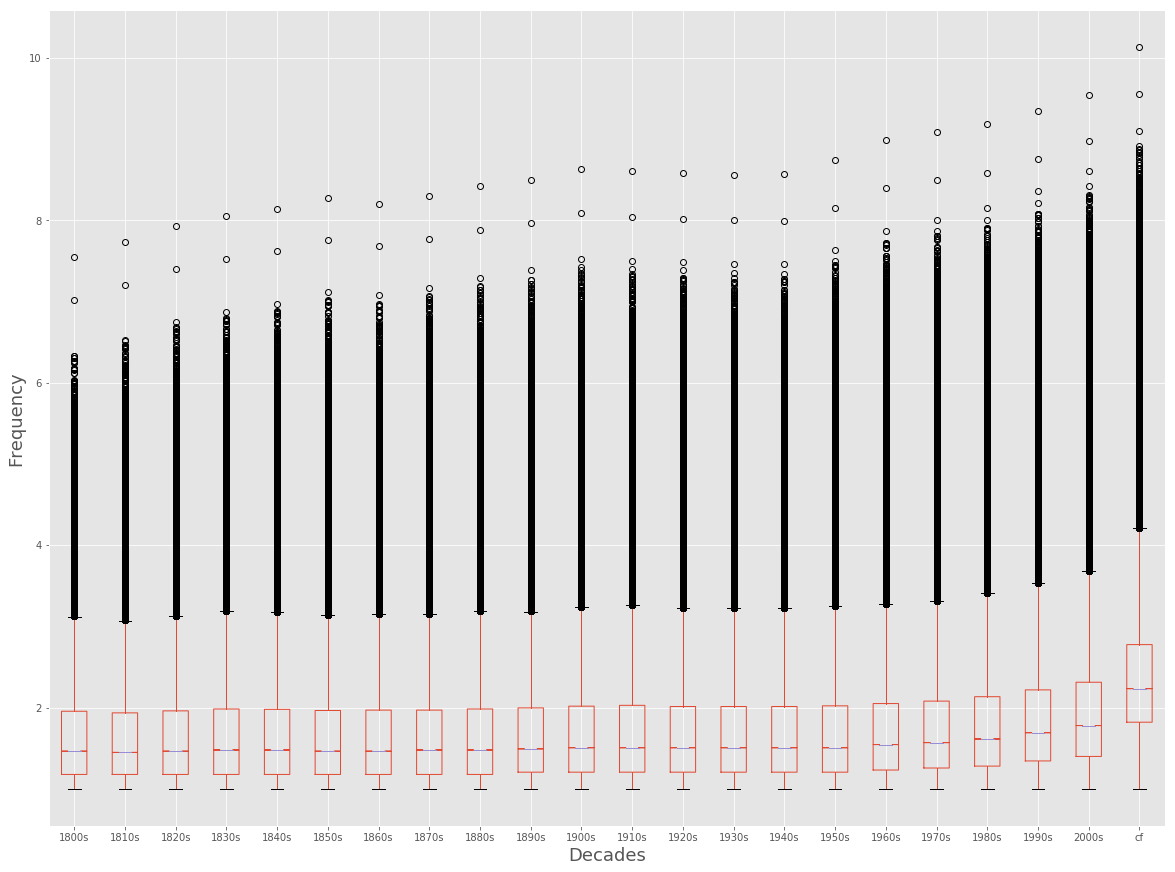

In [64]:

fig, ax = plt.subplots()
unigram.drop('presence',axis=1).plot.box(ax=ax,showfliers=True,figsize=(20,15),legend =True,notch=True)

plt.xlabel('Decades', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5c59d1a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa5fa6f3908>]], dtype=object)

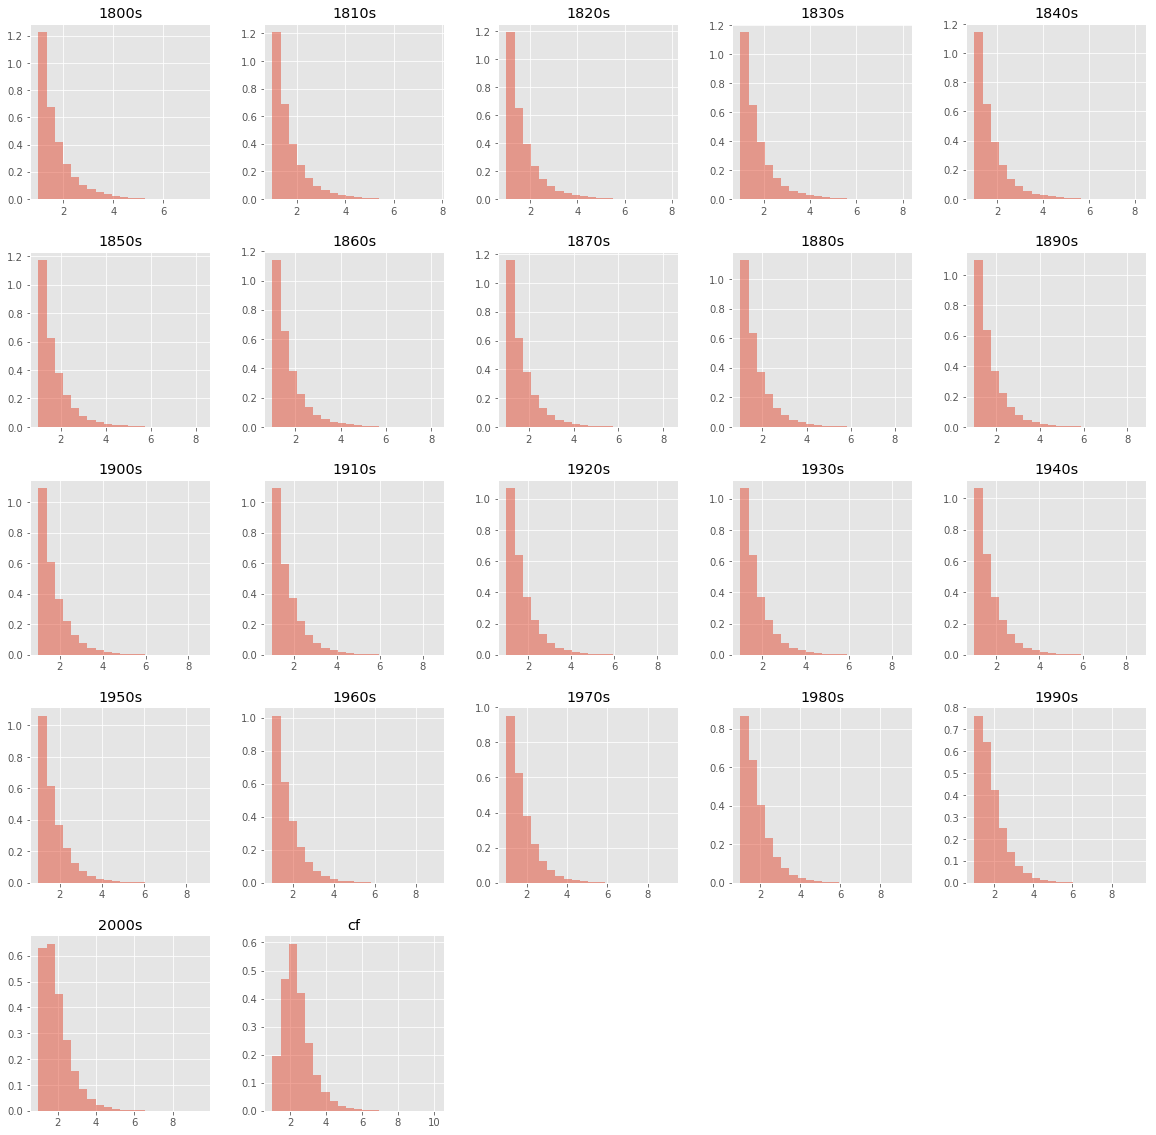

In [67]:
unigram.hist(figsize=(20,20),alpha=0.5,bins=20,normed=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5e75e8a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa67e973470>]], dtype=object)

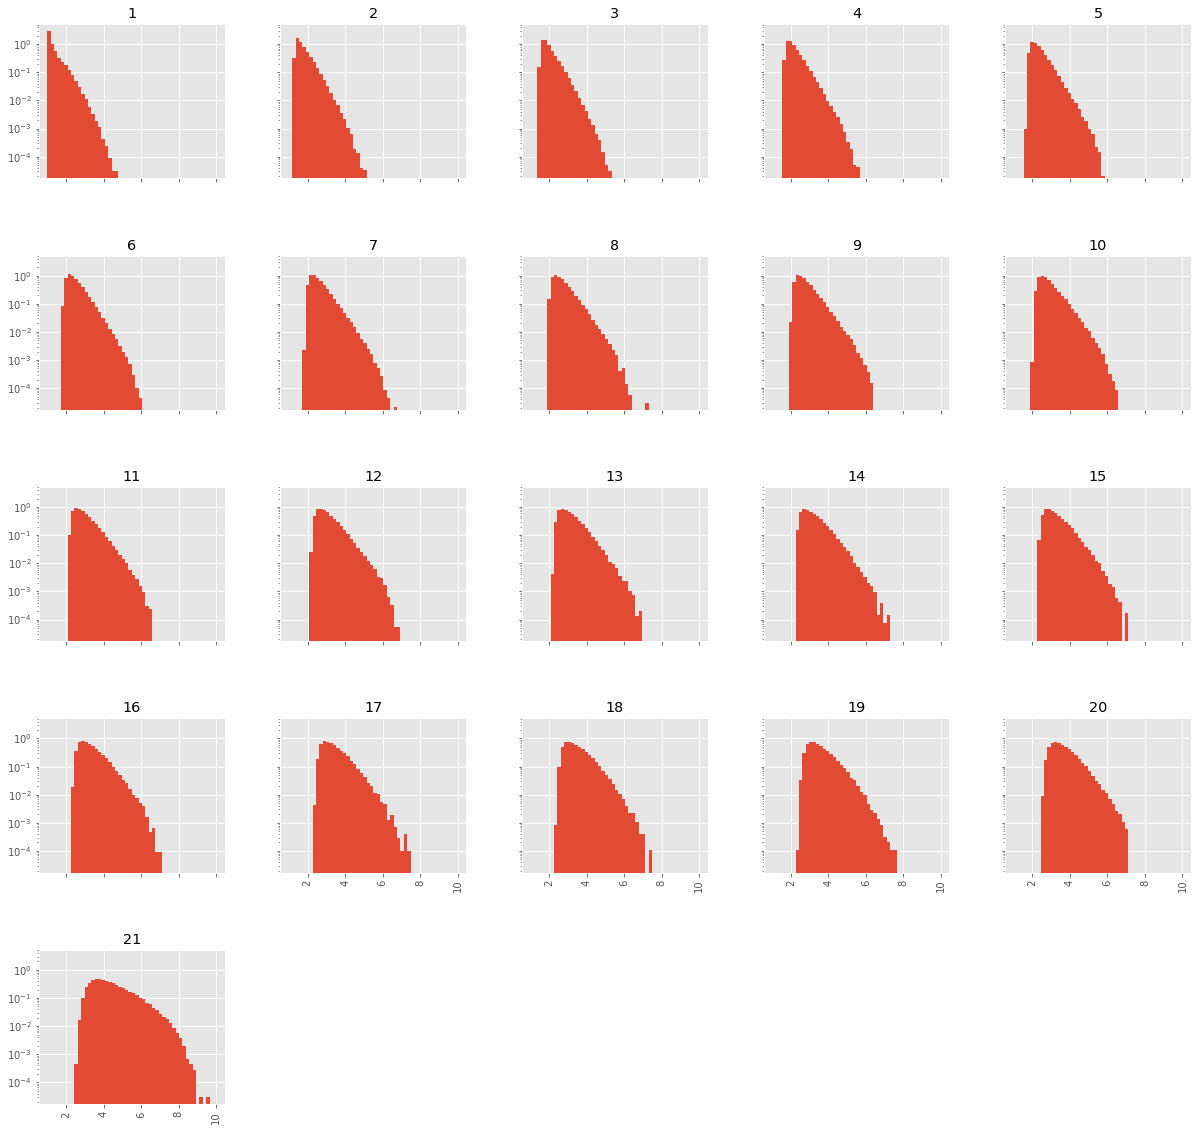

In [69]:
unigram.hist(by= 'presence',column ='cf', figsize=(20, 20),bins=50,sharex=True,log=True,sharey=True,normed=True,range=(1,10))

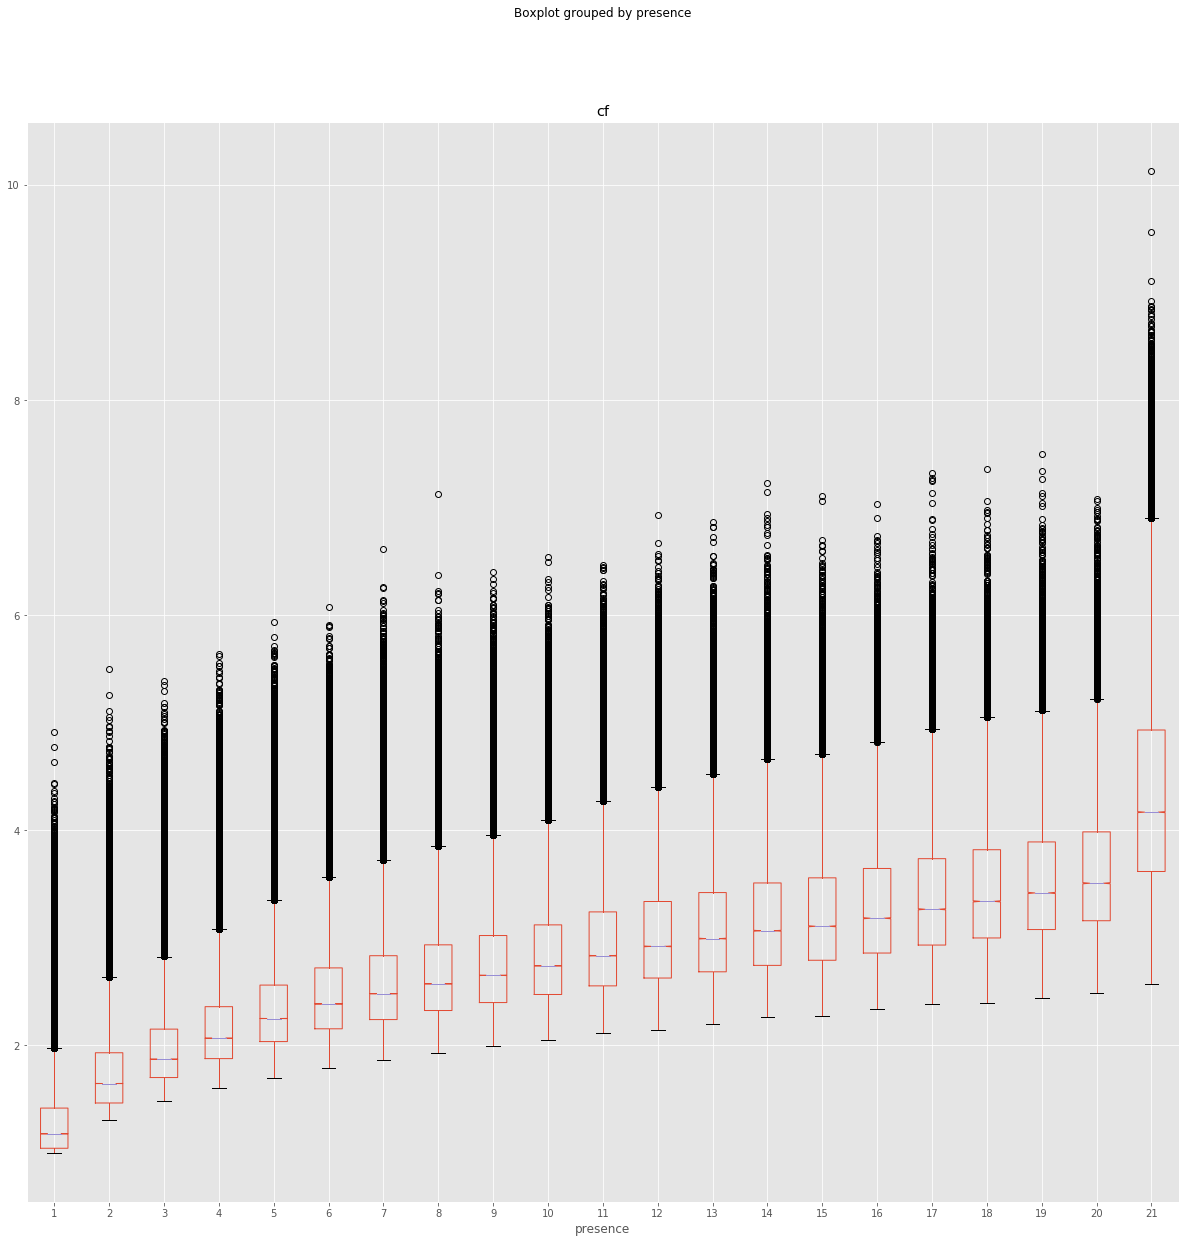

In [70]:
unigram.boxplot(by= 'presence',column ='cf',figsize=(20, 20),notch=True)

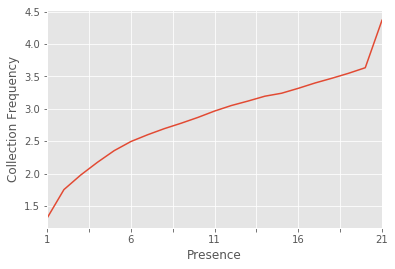

In [71]:
ax=unigram.groupby('presence')['cf'].mean().plot()
ax.set(xlabel="Presence", ylabel="Collection Frequency")

In [15]:
contextwords_df=pd.read_csv("contexts.csv",sep="\t")

41279